**Importing** **Libraries**

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # for Standardization
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC  # for classification
from sklearn.model_selection import GridSearchCV
from sklearn import svm

**Loading Dataset CIFAR10**

In [50]:
cifar10 = tf.keras.datasets.cifar10
(X, y), (X_test, y_test) = cifar10.load_data() # load cifar10

**Split Data Process**

Επειδή ο διαχωρισμός των δεδομένων σε train-test γίνεται αυτόματα σε 90%-10% χρησιμοποιώ την μέθοδο concatenate(), ώστε να ενοποιήσω τα σύνολα εκπαίδευσης - δοκιμής και στη συνέχεια τα ξαναχωρίζω σε train-validation-test με ποσοστά 60%-20%-20%.

**Επιλέγω τυχαία ένα υποσύνολο του συνολικού dataset cifar10.

In [51]:
# combine train and test dataset
X_full = np.concatenate((X, X_test), axis=0)
y_full = np.concatenate((y, y_test), axis=0)

# select a random subset
subset_size = 10000
indices = np.random.choice(len(X_full), size=subset_size, replace=False)
X_full = X_full[indices]
y_full = y_full[indices]

# Split data into train-validation-test sets (60%-20%-20%)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.4,
                                                    random_state=0)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                random_state=0)

**Data** **Preprocessing**

Εαν εμφανίσουμε το σχήμα των δεδομένων εκπαίδευσης - δοκιμής με την μέθοδο
shape() βλέπουμε τις 4 διαστάσεις του πίνακα που περιέχει τις εικόνες.

1. Για τα δεδομένα-εικόνες: Η πρώτη διάσταση δείχνει τον αριθμώ των εικόνων, η δεύτερη και η τρίτη το ύψος και το πλάτος των εικόνων σε pixel και η τέταρτη τον αριθμό των καναλιών χρώματος (RGB).

2. Για τα δεδομένα-labels: Η πρώτη διάσταση δείχνει τον αριθμώ των εικόνων και η δεύτερη ότι για κάθε εικόνα αντιστοιχεί ένα label δηλαδή μία κατηγορία που αναπαριστά κάθε εικόνα.

In [24]:
print("X_train.shape: {}\ny_train.shape: {}\nX_test.shape: {}\ny_test.shape: {}\nX_val.shape: {}\ny_val.shape: {}".format(X_train.shape, y_train.shape,
                                                                                                                          X_test.shape, y_test.shape,
                                                                                                                          X_val.shape, y_val.shape))

X_train.shape: (6000, 32, 32, 3)
y_train.shape: (6000, 1)
X_test.shape: (2000, 32, 32, 3)
y_test.shape: (2000, 1)
X_val.shape: (2000, 32, 32, 3)
y_val.shape: (2000, 1)


Ο SVM δεν μπορεί να επεξεργαστεί δεδομένα εικόνας απευθείας σε μορφή πίνακα 2D ή 3D. Επομένως, για να μπορέσει να δεχθεί τις εικόνες ως δεδομένα εισόδου και να ακολουθήσει η διαδικασία εκπαίδευσης - δοκιμής θα πρέπει πρώτα να γίνει μετατροπή (reshape()) των δεδομένων σε μονοδιάστατα διανύσματα (flat vectors).


In [52]:
# Reshaping Data into vectors
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

print("X_train.shape: {}\ny_train.shape: {}\nX_test.shape: {}\ny_test.shape: {}\nX_val.shape: {}\ny_val.shape: {}".format(X_train.shape, y_train.shape,
                                                                                                                          X_test.shape, y_test.shape,
                                                                                                                          X_val.shape, y_val.shape))

X_train.shape: (6000, 3072)
y_train.shape: (6000, 1)
X_test.shape: (2000, 3072)
y_test.shape: (2000, 1)
X_val.shape: (2000, 3072)
y_val.shape: (2000, 1)


Για τη βελτίωση της απόδοσης του SVM είναι απαραίτητες η "Κανονικοποίηση" των δεδομένων και η "Μέθοδος Ανάλυσης Κύριων Συνιστωσών" (PCA).

Κάνουμε κανονικοποίηση/ για να εξασφαλίσουμε ότι όλα τα χαρακτηρισιτκά έχουν την ίδια κλίμακα, έτσι ώστε να μην κυριαρχούν χαρακτηριστικά σε μεγάλες τιμές στην pca.

Πριν κάνω pca βλέπω πόσες συνιστώσες μπορώ κρατήσω ώστε να κρατήσω όσο το δυνατόν περισσότερη πληροφορία.

Text(0, 0.5, 'cumulative explained variance')

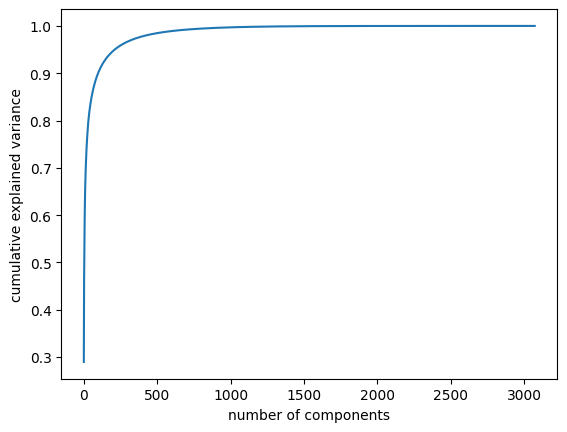

In [26]:
combined=np.vstack((X_train, X_val))

pca = PCA().fit(combined)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [27]:
print(pca.explained_variance_ratio_.cumsum()[50])
print(pca.explained_variance_ratio_.cumsum()[100])
print(pca.explained_variance_ratio_.cumsum()[150])
print(pca.explained_variance_ratio_.cumsum()[500])

0.8447474475084383
0.9023471092816866
0.9302919201413027
0.9848081911564363


In [53]:
# Standardization of data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
# Normalization
# X_train = X_train / 255.0
# X_test = X_test / 255.0
# X_val = X_val / 255.0

Με το PCA επιτυγχάνεται η μείωση διάστασης των δεδομένων κρατώντας τις πιο σημαντικές συνιστώσες δηλαδή επιτυγχάνεται η αναδόμηση των δεδομένων σε νέες διαστάσεις, δίνοντας ίση βαρύτητα σε όλα τα χαρακτηριστικά εφόσον έχουν προηγηθεί είτε Normalization είτε Standardization.

In [54]:
# pca for dimensionality reduction
pca_cifar = PCA(n_components=100)
X_train = pca_cifar.fit_transform(X_train)
X_test = pca_cifar.transform(X_test)
X_val = pca_cifar.transform(X_val)

print("X_train.shape: {}\ny_train.shape: {}\nX_test.shape: {}\ny_test.shape: {}\nX_val.shape: {}\ny_val.shape: {}".format(X_train.shape, y_train.shape,
                                                                                                                          X_test.shape, y_test.shape,
                                                                                                                          X_val.shape, y_val.shape))

X_train.shape: (6000, 100)
y_train.shape: (6000, 1)
X_test.shape: (2000, 100)
y_test.shape: (2000, 1)
X_val.shape: (2000, 100)
y_val.shape: (2000, 1)


**Model** **Training**

Types of Kernel: Linear, RBF, Polynomial

SVM Linear Kernel

Δοκιμάζω διαφορετικές τιμές της παραμέτρου C (regularization parameter).
Δημιουργία μεθόδου linear_model_method (), η οποία θα παίρνει ως όρισμα διαφορετικές παραμέτρους C από μία λίστα που θα δημιουργήσω.

In [55]:
# Prepare variables to store the results
train_set_accuracy = []
val_set_caccuracy = []
test_set_accuracy = []
results = []

# Function to train SVM with Linear Kernel
def linear_model_SVM (c):
    start_time = time.time()
    svm_classifier = SVC(kernel='linear', C=c)

    svm_classifier.fit(X_train, y_train.ravel())

    # Accuracy for train set
    pred = svm_classifier.predict(X_train)
    acc_train = np.mean(pred == y_train.ravel())
    train_set_accuracy.append(acc_train)
    print("Train Accuracy for C = {}: {}".format(c, acc_train))

    # Accuracy for validation set
    pred = svm_classifier.predict(X_val)
    acc_val = np.mean(pred == y_val.ravel())
    val_set_caccuracy.append(acc_val)
    print("Validation Accuracy for C = {}: {}".format(c, acc_val))

    # Accuracy for test set
    pred = svm_classifier.predict(X_test)
    acc_test = np.mean(pred == y_test.ravel())
    test_set_accuracy.append(acc_test)
    print("Test Accuracy for C = {}: {}".format(c, acc_test))

    # Run time
    end_time = time.time()
    run_time = end_time - start_time

    results.append({
            'Kernel': 'linear',
            'C': c,
            'Train Accuracy': acc_train,
            'Validation Accuracy': acc_val,
            'Test Accuracy': acc_test,
            'Run time: ': run_time
            })

Train Accuracy for C = 0.0001: 0.4121666666666667
Validation Accuracy for C = 0.0001: 0.372
Test Accuracy for C = 0.0001: 0.349
Train Accuracy for C = 0.0005: 0.44766666666666666
Validation Accuracy for C = 0.0005: 0.387
Test Accuracy for C = 0.0005: 0.3605
Train Accuracy for C = 0.001: 0.45716666666666667
Validation Accuracy for C = 0.001: 0.3845
Test Accuracy for C = 0.001: 0.3675
Train Accuracy for C = 0.005: 0.46166666666666667
Validation Accuracy for C = 0.005: 0.3765
Test Accuracy for C = 0.005: 0.3675
Train Accuracy for C = 0.01: 0.465
Validation Accuracy for C = 0.01: 0.3745
Test Accuracy for C = 0.01: 0.3645
Train Accuracy for C = 0.05: 0.4701666666666667
Validation Accuracy for C = 0.05: 0.3685
Test Accuracy for C = 0.05: 0.364
Train Accuracy for C = 0.1: 0.4705
Validation Accuracy for C = 0.1: 0.3695
Test Accuracy for C = 0.1: 0.364


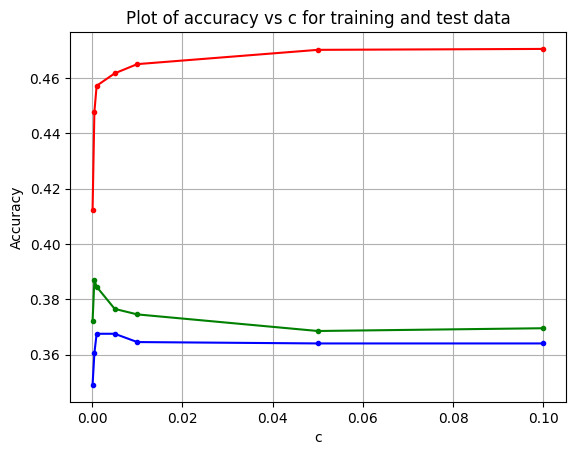

In [56]:
# Run SVM model for different C values
C_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

for c in C_values:
  linear_model_SVM(c)

# Print the results
plt.plot(C_values, train_set_accuracy,'.-',color='red')
plt.plot(C_values, test_set_accuracy,'.-',color='blue')
plt.plot(C_values, val_set_caccuracy,'.-',color='green')
plt.title("Plot of accuracy vs c for training and test data")
plt.xlabel('c')
plt.ylabel('Accuracy')
plt.grid()

In [57]:
# Create a dataframe with the results
results_df = pd.DataFrame(results)
results_df

,Kernel,C,Train Accuracy,Validation Accuracy,Test Accuracy,Run time:
0,linear,0.0001,0.412167,0.3720,0.3490,7.725827
1,linear,0.0005,0.447667,0.3870,0.3605,9.186107
2,linear,0.0010,0.457167,0.3845,0.3675,10.426969
3,linear,0.0050,0.461667,0.3765,0.3675,9.821838
4,linear,0.0100,0.465000,0.3745,0.3645,12.406786
5,linear,0.0500,0.470167,0.3685,0.3640,45.237365
6,linear,0.1000,0.470500,0.3695,0.3640,83.031582


Παρατήρησεις:

Για μικρό σύνολο δεδομένων (1000) το accuracy του train set αυξάνεται καθώς αυξάνεται και η τιμή του C (παράγοντας κανονικοποίησης). Αυτό υποδηλώνει ότι το μοντέλο κάνει overfitting, δηλαδή υπερπροσαρμόζεται στα δεδομένα εκπαίδευσης, αλλά αδυνατεί να γενικεύσει με επιτυχία σε νέα δεδομένα. Αυτό φαίνεται στις τιμές των validation και test accuracies, οι οποίες είναι χαμηλές.

SVM RBF Kernel

In [58]:
# Function to train SVM with RBF Kernel
def rbf_model_SVM (C, g):

    start_time = time.time()

    svm_classifier = SVC(kernel='rbf', C=c, gamma=g)

    svm_classifier.fit(X_train, y_train.ravel())

    # Accuracy for train set
    pred = svm_classifier.predict(X_train)
    acc_train = np.mean(pred == y_train.ravel())
    train_set_accuracy.append(acc_train)
    print("Train Accuracy for C = {}: {}".format(c, acc_train))

    # Accuracy for validation set
    pred = svm_classifier.predict(X_val)
    acc_val = np.mean(pred == y_val.ravel())
    val_set_accuracy.append(acc_val)
    print("Validation Accuracy for C = {}: {}".format(c, acc_val))

    # Accuracy for test set
    pred = svm_classifier.predict(X_test)
    acc_test = np.mean(pred == y_test.ravel())
    test_set_accuracy.append(acc_test)
    print("Test Accuracy for C = {}: {}".format(c, acc_test))

    # Run time
    end_time = time.time()
    run_time = end_time - start_time

    results.append({
              'Kernel': 'RBF',
              'C': c,
              'Train Accuracy': acc_train,
              'Validation Accuracy': acc_val,
              'Test Accuracy': acc_test,
               'Run time: ': run_time
                  })

Train Accuracy for C = 0.0001: 0.10933333333333334
Validation Accuracy for C = 0.0001: 0.104
Test Accuracy for C = 0.0001: 0.0925
Train Accuracy for C = 0.0005: 0.10933333333333334
Validation Accuracy for C = 0.0005: 0.104
Test Accuracy for C = 0.0005: 0.0925
Train Accuracy for C = 0.001: 0.10933333333333334
Validation Accuracy for C = 0.001: 0.104
Test Accuracy for C = 0.001: 0.0925
Train Accuracy for C = 0.005: 0.10933333333333334
Validation Accuracy for C = 0.005: 0.104
Test Accuracy for C = 0.005: 0.0925
Train Accuracy for C = 0.01: 0.10933333333333334
Validation Accuracy for C = 0.01: 0.104
Test Accuracy for C = 0.01: 0.0925
Train Accuracy for C = 0.05: 0.10933333333333334
Validation Accuracy for C = 0.05: 0.104
Test Accuracy for C = 0.05: 0.0925
Train Accuracy for C = 0.1: 0.10933333333333334
Validation Accuracy for C = 0.1: 0.104
Test Accuracy for C = 0.1: 0.0925


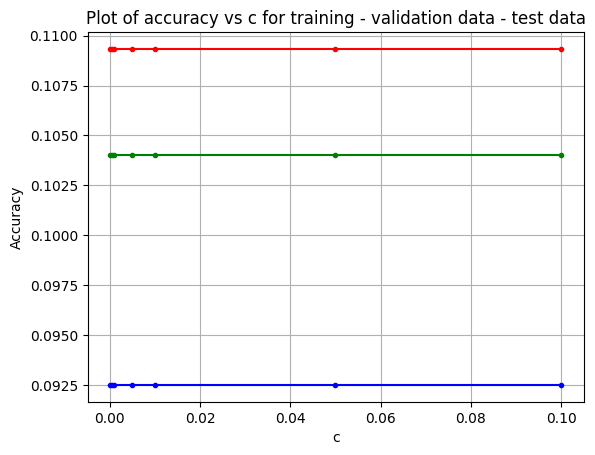

In [59]:
C_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
# C_values =  [0.0001, 0.001, 0.01, 0.1, 1]

# Prepare variables to store the results
train_set_accuracy = []
val_set_accuracy = []
test_set_accuracy = []
results = []

for c in C_values:
  rbf_model_SVM(c, 'auto')

# Print the results
plt.plot(C_values, train_set_accuracy,'.-',color='red')
plt.plot(C_values, test_set_accuracy,'.-',color='blue')
plt.plot(C_values, val_set_accuracy,'.-',color='green')
plt.title("Plot of accuracy vs c for training - validation data - test data")
plt.xlabel('c')
plt.ylabel('Accuracy')
plt.grid()

In [60]:
# Create a dataframe with the results
results_df = pd.DataFrame(results)
results_df

,Kernel,C,Train Accuracy,Validation Accuracy,Test Accuracy,Run time:
0,RBF,0.0001,0.109333,0.104,0.0925,15.232548
1,RBF,0.0005,0.109333,0.104,0.0925,15.117763
2,RBF,0.0010,0.109333,0.104,0.0925,14.890062
3,RBF,0.0050,0.109333,0.104,0.0925,14.968845
4,RBF,0.0100,0.109333,0.104,0.0925,14.972302
5,RBF,0.0500,0.109333,0.104,0.0925,15.035532
6,RBF,0.1000,0.109333,0.104,0.0925,14.979667


Polynomial Kernel

In [61]:
# Prepare variables to store the results
train_set_accuracy = []
val_set_caccuracy = []
test_set_accuracy = []
results = []

def poly_model_SVM (C):
      start_time = time.time()
      svm_classifier = SVC(probability= False, kernel='poly', C=c)

      svm_classifier.fit(X_train, y_train.ravel())

      # Accuracy for train set
      pred = svm_classifier.predict(X_train)
      acc_train = np.mean(pred == y_train.ravel())
      train_set_accuracy.append(acc_train)
      print("Train Accuracy for C = {}: {}".format(c, acc_train))

      # Accuracy for validation set
      pred = svm_classifier.predict(X_val)
      acc_val = np.mean(pred == y_val.ravel())
      val_set_caccuracy.append(acc_val)
      print("Validation Accuracy for C = {}: {}".format(c, acc_val))

      # Accuracy for test set
      pred = svm_classifier.predict(X_test)
      acc_test = np.mean(pred == y_test.ravel())
      test_set_accuracy.append(acc_test)
      print("Test Accuracy for C = {}: {}".format(c, acc_test))

      # Run time
      end_time = time.time()
      run_time = end_time - start_time

      results.append({
              'Kernel': 'Polynomial',
              'C': c,
              'Train Accuracy': acc_train,
              'Validation Accuracy': acc_val,
              'Test Accuracy': acc_test
                  })

Train Accuracy for C = 0.0001: 0.10933333333333334
Validation Accuracy for C = 0.0001: 0.104
Test Accuracy for C = 0.0001: 0.0925
Train Accuracy for C = 0.0005: 0.10966666666666666
Validation Accuracy for C = 0.0005: 0.104
Test Accuracy for C = 0.0005: 0.093
Train Accuracy for C = 0.001: 0.11416666666666667
Validation Accuracy for C = 0.001: 0.106
Test Accuracy for C = 0.001: 0.0975
Train Accuracy for C = 0.005: 0.12633333333333333
Validation Accuracy for C = 0.005: 0.117
Test Accuracy for C = 0.005: 0.1095
Train Accuracy for C = 0.01: 0.15116666666666667
Validation Accuracy for C = 0.01: 0.138
Test Accuracy for C = 0.01: 0.1295
Train Accuracy for C = 0.05: 0.24866666666666667
Validation Accuracy for C = 0.05: 0.212
Test Accuracy for C = 0.05: 0.2045
Train Accuracy for C = 0.1: 0.319
Validation Accuracy for C = 0.1: 0.245
Test Accuracy for C = 0.1: 0.232


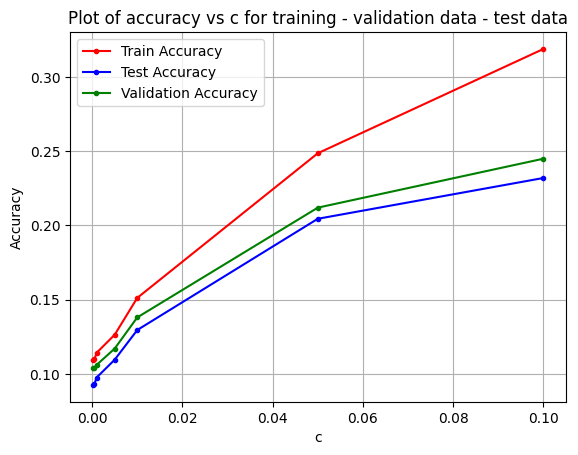

In [62]:
C_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

train_set_accuracy = []
val_set_caccuracy = []
test_set_accuracy = []
results = []
for c in C_values:
  poly_model_SVM(c)

# Print the results
plt.plot(C_values, train_set_accuracy,'.-',color='red')
plt.plot(C_values, test_set_accuracy,'.-',color='blue')
plt.plot(C_values, val_set_caccuracy,'.-',color='green')
plt.legend(['Train Accuracy', 'Test Accuracy', 'Validation Accuracy'])
plt.title("Plot of accuracy vs c for training - validation data - test data")
plt.xlabel('c')
plt.ylabel('Accuracy')
plt.grid()

In [63]:
# Create a dataframe with the results
results_df = pd.DataFrame(results)
results_df

,Kernel,C,Train Accuracy,Validation Accuracy,Test Accuracy
0,Polynomial,0.0001,0.109333,0.104,0.0925
1,Polynomial,0.0005,0.109667,0.104,0.0930
2,Polynomial,0.0010,0.114167,0.106,0.0975
3,Polynomial,0.0050,0.126333,0.117,0.1095
4,Polynomial,0.0100,0.151167,0.138,0.1295
5,Polynomial,0.0500,0.248667,0.212,0.2045
6,Polynomial,0.1000,0.319000,0.245,0.2320


Classifier 2: Grid Search - Cross Validation

In [64]:
# defining parameter range
param_grid = {'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
              'gamma': ['scale', 'auto'],
              'kernel': ['linear', 'rbf', 'poly']}
# svm classifier
svm_classifier2 = SVC()

# grid search
grid_search = GridSearchCV(svm_classifier2, param_grid, cv=5, n_jobs=-1)  # cv=5 για 5-fold cross-validation

# train grid_search
grid_search.fit(X_train, y_train.ravel())

# find best parameters of grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 0.0005, 'gamma': 'scale', 'kernel': 'linear'}


In [65]:
acc = grid_search.best_score_
print("Best Accuracy:", acc)

Best Accuracy: 0.3788333333333333


In [66]:
# Train set Accuracy
y_train_pred = grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train.ravel(), y_train_pred)
print("Train Set Accuracy:", train_accuracy)

# Validation set Accuracy
y_val_pred = grid_search.predict(X_val)
val_accuracy = accuracy_score(y_val.ravel(), y_val_pred)
print("Validation Set Accuracy:", val_accuracy)

# Test set Accuracy
y_test_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test.ravel(), y_test_pred)
print("Test Set Accuracy:", test_accuracy)


Train Set Accuracy: 0.44766666666666666
Validation Set Accuracy: 0.387
Test Set Accuracy: 0.3605


In [67]:
import pandas as pd

pred = grid_search.predict(X_test)
svm_results = pred[:20].ravel()
yTest_results = y_test[:20].ravel()

# DataFrame with predicted and actual values
results_df = pd.DataFrame({
    'Prediction': svm_results,
    'Actual Value': yTest_results
})

# print the dataframe
print(results_df)

    Prediction  Actual Value
0            4             2
1            0             0
2            4             6
3            5             2
4            7             7
5            7             1
6            8             8
7            7             2
8            4             2
9            8             0
10           9             2
11           6             6
12           1             9
13           1             8
14           7             7
15           4             2
16           4             4
17           1             1
18           1             1
19           6             4


In [68]:
# Create lists for correct and incorrect predictions
correct_predictions = []
incorrect_predictions = []

for i in range(len(svm_results)):
    if svm_results[i] == yTest_results[i]:
        correct_predictions.append(i)
    else:
        incorrect_predictions.append(i)

print("Correct Predictions:", correct_predictions)
print("Incorrect Predictions:", incorrect_predictions)

Correct Predictions: [1, 4, 6, 11, 14, 16, 17, 18]
Incorrect Predictions: [0, 2, 3, 5, 7, 8, 9, 10, 12, 13, 15, 19]


In [69]:
# Data reconstruction
X_test_reconstructed = pca_cifar.inverse_transform(X_test)

X_test_reconstructed = np.clip(X_test_reconstructed, 0, 1)
X_test_reconstructed = X_test_reconstructed.astype(np.float32)

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Class names
classesName = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Image preparation
def plt_img(x):
    nrow = 32
    ncol = 32
    ncolors = 3
    xsq = x.reshape((nrow, ncol, ncolors))
    plt.imshow(xsq)

# Number of images to plot (2 correct & 2 incorrect)
nplt = 2

# Plot correct predictions
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<ipython-input-71-a4b6111b0d69>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = classesName[int(y_test[ind])]  # actual label


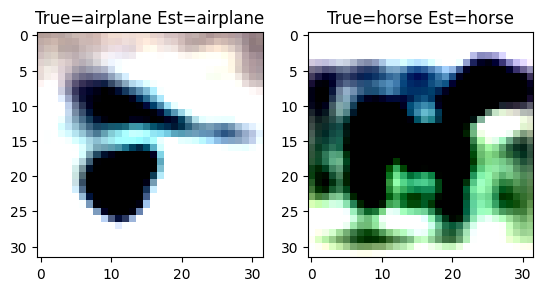

In [71]:
# Plot correct predictions
for i in range(nplt):
   plt.subplot(1, nplt, i + 1)
   ind = correct_predictions[i]  # select the correct sample
   plt_img(X_test_reconstructed[ind, :])  # use of reconstructed data for plotting

   # Actual and Predicted label
   true_label = classesName[int(y_test[ind])]  # actual label
   est_label = classesName[int(pred[ind])]  # predicted label

   # Τίτλος εικόνας
   plt.title(f'True={true_label} Est={est_label}')

<ipython-input-49-3872a8d3e326>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = classesName[int(y_test[ind])]  # actual label


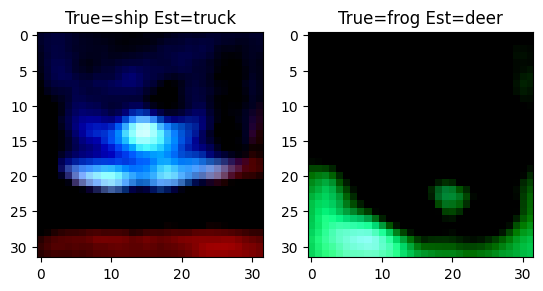

In [49]:
# Plot incorrect predictions
for i in range(nplt):
    plt.subplot(1, nplt, i + 1)
    ind = incorrect_predictions[i] # select the incorrect sample
    plt_img(X_test_reconstructed[ind, :]) # use of reconstructed data for plotting

    # Actual and Predicted label
    true_label = classesName[int(y_test[ind])]  # actual label
    est_label = classesName[int(pred[ind])]  # predicted label

    # Τίτλος εικόνας
    plt.title(f'True={true_label} Est={est_label}')